In [1]:
import os
import openai
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv()) 
openai.api_key  = os.getenv('OPENAI_API_KEY')

## This is Causal Flow for GRC Policy

- This is created from domain knowledge of the GRC engineers
- At some point, we could expect to derive this from reading of code
- If so, it will help streamline things even more

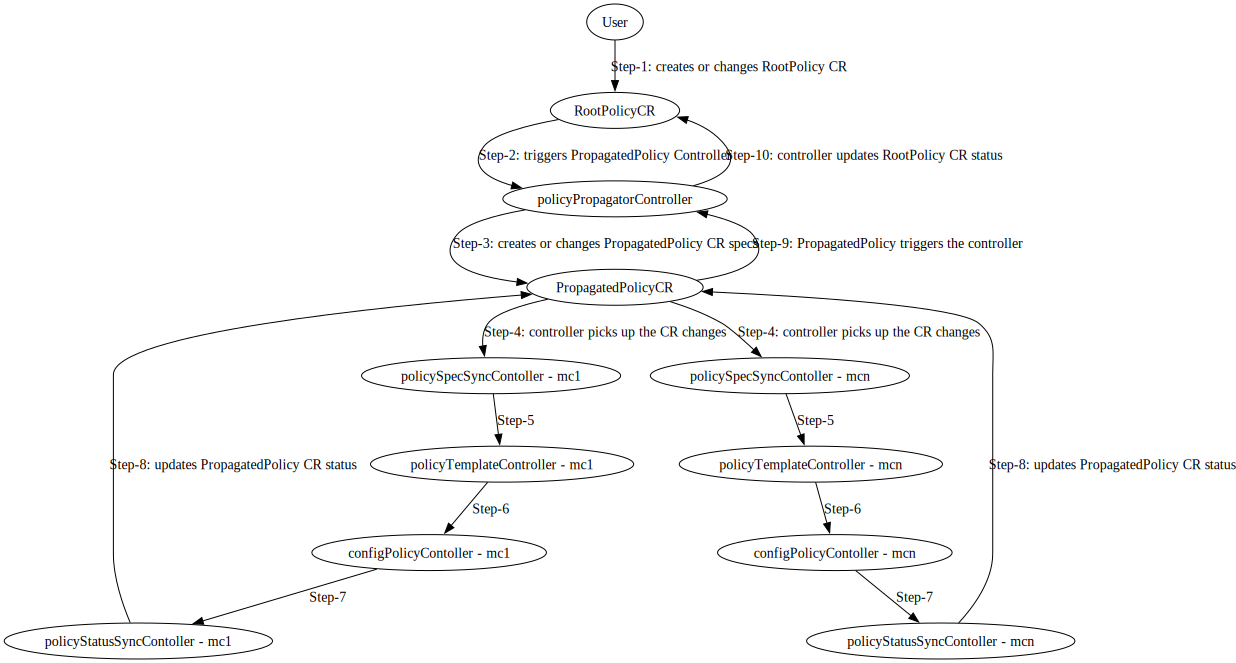

In [2]:
import networkx as nx
import graphviz


acmpolicycomplete=graphviz.Digraph()

acmpolicycomplete.edge('User','RootPolicyCR', label="Step-1: creates or changes RootPolicy CR")

acmpolicycomplete.edge('RootPolicyCR','policyPropagatorController', label="Step-2: triggers PropagatedPolicy Controller")


acmpolicycomplete.edge('policyPropagatorController','PropagatedPolicyCR', label="Step-3: creates or changes PropagatedPolicy CR specs")


acmpolicycomplete.edge('PropagatedPolicyCR','policySpecSyncContoller - mc1', label="Step-4: controller picks up the CR changes")
acmpolicycomplete.edge('PropagatedPolicyCR','policySpecSyncContoller - mcn', label="Step-4: controller picks up the CR changes")

acmpolicycomplete.edge('policySpecSyncContoller - mc1','policyTemplateController - mc1', label="Step-5")
acmpolicycomplete.edge('policySpecSyncContoller - mcn','policyTemplateController - mcn', label="Step-5")

acmpolicycomplete.edge('policyTemplateController - mc1','configPolicyContoller - mc1', label="Step-6")
acmpolicycomplete.edge('policyTemplateController - mcn','configPolicyContoller - mcn', label="Step-6")

acmpolicycomplete.edge('configPolicyContoller - mc1','policyStatusSyncContoller - mc1', label="Step-7")
acmpolicycomplete.edge('configPolicyContoller - mcn','policyStatusSyncContoller - mcn', label="Step-7")

acmpolicycomplete.edge('policyStatusSyncContoller - mc1','PropagatedPolicyCR', label="Step-8: updates PropagatedPolicy CR status")
acmpolicycomplete.edge('policyStatusSyncContoller - mcn','PropagatedPolicyCR', label="Step-8: updates PropagatedPolicy CR status")

acmpolicycomplete.edge('PropagatedPolicyCR','policyPropagatorController', label="Step-9: PropagatedPolicy triggers the controller")
acmpolicycomplete.edge('policyPropagatorController','RootPolicyCR', label="Step-10: controller updates RootPolicy CR status")

acmpolicycomplete

## Enter LLM

- A GRC Engineer, uses the above causal graph in his/her head to answer amazingly complex questions
- Let us see if we feed the same information to LLM, how well it does

In [3]:
GRC_PROMPT = """You underdstand Red Hat Advanced cluster management, GRC Pillar well.\
We are giving you details about the GRC topology, \
such as the relationships between nodes, paths, connectivity, and other related queries \
You will be provided the topology as a  Graphviz digraph : {composition}. \
Answer the question based on the above topology and your knowledge about ACM GRC.\
A few other things to keep in mind: \
There are 3 types of nodes here: CRs, Controllers and Personas.\
The nodes that has name ending in CR are actually Kubernetes custom resources.\
The nodes that has name ending in Controller actually Kubernetes Controllers.\
There is a User node - which represents the real user taking an action.\
The location of Nodes is also encoded in the topology.\
Nodes which has names ending with "-mc*" means they happen on a managed cluster. \
So mc-1, mc-2, mc-n just means these are running on mc that is managed cluster.\
And there can be 1, 2 to n number of managed clusters.
Nodes that does not end by that are running on the hub cluster. \
Needless to say, the hub cluster manages the "managed" cluster because this describes ACM GRC topology.\
In the answer do not refer to the topology diagram. The user may not have access to it."""




#"""You underdstand Red Hat Advanced cluster management, GRC Pillar well.\
#You are an expert at answering questions about a topology, \
#such as the relationships between nodes, paths, connectivity, and other related queries \
#You will be provided the topology as a  Graphviz digraph : {composition}. \
#Answer the question based on the above topology.\
#A few other things to keep in mind: \
#There are 3 types of nodes here: CRs, Controllers and Personas.\
#The nodes that has name ending in CR are actually Kubernetes custom resources.\
#The nodes that has name ending in Controller actually Kubernetes Controllers.\
#There is a User node - which represents the real user taking an action.\
#The location of Nodes is also encoded in the topology.\
#Nodes which has names ending with "-mc*" means they happen on a managed cluster. \
#So mc-1, mc-2, mc-n just means these are running on mc that is managed cluster.\
#And there can be 1, 2 to n number of managed clusters.
#Nodes that does not end by that are running on the hub cluster. \
#Needless to say, the hub cluster manages the "managed" cluster because this describes ACM GRC topology.\
#In the answer do not refer to the topology diagram. The user may not have access to it."""


#### Just taking the GRC causal graph and adding it to LLM as a prompt.

- There is probably is a more elegant way to do this other than cut pasting!
- Let us also see if this is more effective in answering questions than using:
    - the same causal knowledge graph in graph databse
    - with a graphdb agent with LLM

In [4]:
composition = """
acmpolicycomplete=graphviz.Digraph()\

acmpolicycomplete.edge('User','RootPolicyCR', label="Step-1: creates or changes RootPolicy CR")\

acmpolicycomplete.edge('RootPolicyCR','policyPropagatorController', label="Step-2: triggers PropagatedPolicy Controller")\


acmpolicycomplete.edge('policyPropagatorController','PropagatedPolicyCR', label="Step-3: creates or changes PropagatedPolicy CR specs")\


acmpolicycomplete.edge('PropagatedPolicyCR','policySpecSyncContoller - mc1', label="Step-4: controller picks up the CR changes")\
acmpolicycomplete.edge('PropagatedPolicyCR','policySpecSyncContoller - mcn', label="Step-4: controller picks up the CR changes")\

acmpolicycomplete.edge('policySpecSyncContoller - mc1','policyTemplateController - mc1', label="Step-5")\
acmpolicycomplete.edge('policySpecSyncContoller - mcn','policyTemplateController - mcn', label="Step-5")\

acmpolicycomplete.edge('policyTemplateController - mc1','configPolicyContoller - mc1', label="Step-6")\
acmpolicycomplete.edge('policyTemplateController - mcn','configPolicyContoller - mcn', label="Step-6")\

acmpolicycomplete.edge('configPolicyContoller - mc1','policyStatusSyncContoller - mc1', label="Step-7")\
acmpolicycomplete.edge('configPolicyContoller - mcn','policyStatusSyncContoller - mcn', label="Step-7")\

acmpolicycomplete.edge('policyStatusSyncContoller - mc1','PropagatedPolicyCR', label="Step-8: updates PropagatedPolicy CR status")\
acmpolicycomplete.edge('policyStatusSyncContoller - mcn','PropagatedPolicyCR', label="Step-8: updates PropagatedPolicy CR status")\

acmpolicycomplete.edge('PropagatedPolicyCR','policyPropagatorController', label="Step-9: PropagatedPolicy triggers the controller")\
acmpolicycomplete.edge('policyPropagatorController','RootPolicyCR', label="Step-10: controller updates RootPolicy CR status")\


acmpolicycomplete\
"""

In [5]:
msgs = ["What components run on the hub cluster and what components run on spoke cluster. Describe it in terms of Controllers, CRs, personas",\
        "After the user creates a policy on the hub cluster, how does it propagate to the managed cluster. In the answer do not refer to the topology diagram.",\
       "The user is saying they do not see the policy being propagated - they are looking at the hub server only.Can you suggest what may have gone wrong. Say outline 3 possible causes in order of likelihood", \
        "As a policy user, why am I not seeing Policy Status Changes for some managed clusters",\
        "As a policy user, why am I seeing too many Policy Status Changes for a managed cluster",\
        "Why is my policy not applying the configuration defined on the managed cluster",\
        "Do you know how the policySpecSync Contoller on the managed cluster gets information about changes to PropagatedPolicy CRs on the Hub. Remember they are on different kubernetes clusters",\
        "Do you know how a kubernetes controller works",\
        "Can you give an example of a sample GRC policy explaining what it does"
      ]

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

In [7]:
#modela = ChatOpenAI(model="gpt-4", temperature=0)
#responsea = modela.invoke("Do you know anything about Red Hat Advanced cluster management, GRC Pillar ?")
#print(responsea.content)
#print("------------------------")
#print("------------------------")
#responseb = modela.invoke("What components run on the hub cluster and what components run on spoke cluster to support the GRC functionality")
#print(responseb.content)

In [8]:
for msg in msgs:
    messages = [
            SystemMessage(content=GRC_PROMPT.format(composition=composition)), 
            HumanMessage(content=msg)        
       ]

    # The quality of answer from gpt-4 is much better than gpt-3.5-turbo
    # This is probably because we are using LLM's strength to understand 
    # topological data.
    model = ChatOpenAI(model="gpt-4", temperature=0)
    response = model.invoke(messages)
    print("")
    print("--------------")
    print(msg)
    print("--------------")
    print(response.content)


--------------
What components run on the hub cluster and what components run on spoke cluster. Describe it in terms of Controllers, CRs, personas
--------------
On the hub cluster, we have the following components:

1. Controllers: The 'policyPropagatorController' runs on the hub cluster. This controller is responsible for triggering the PropagatedPolicy Controller when a RootPolicy Custom Resource (CR) is created or changed.

2. Custom Resources (CRs): The 'RootPolicyCR' and 'PropagatedPolicyCR' are the CRs that exist on the hub cluster. The 'RootPolicyCR' is created or changed by the user, which then triggers the 'policyPropagatorController'. The 'PropagatedPolicyCR' is created or changed by the 'policyPropagatorController' and it also triggers the 'policyPropagatorController' after its status is updated by the 'policyStatusSyncController' on the managed cluster.

3. Personas: The 'User' persona is on the hub cluster. This persona represents the real user who creates or changes the


--------------
Do you know how the policySpecSync Contoller on the managed cluster gets information about changes to PropagatedPolicy CRs on the Hub. Remember they are on different kubernetes clusters
--------------
Yes, the policySpecSync Controller on the managed cluster gets information about changes to PropagatedPolicy CRs on the Hub through a process called "propagation". 

Here's how it works:

1. When a user creates or changes a RootPolicy Custom Resource (CR) on the hub cluster, it triggers the policyPropagatorController.

2. The policyPropagatorController then creates or changes the PropagatedPolicy CR specs. 

3. These changes are picked up by the policySpecSyncController on each managed cluster (mc1, mcn, etc.). This is possible because the policySpecSyncController is constantly watching for changes to the PropagatedPolicy CRs.

4. Once the policySpecSyncController detects a change, it triggers the policyTemplateController on the same managed cluster.

This propagation proc